In [98]:
import sys
import os

import pandas as pd
import numpy as np
import loompy
import velocyto as vcy

import matplotlib
import matplotlib.pyplot as plt

import logging
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42

2019-11-12 12:47:56,403 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [99]:
def despline():
    ax1 = plt.gca()
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    
def minimal_xticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    xlims = np.linspace(start, end_, 5)
    xlims_tx = [""]*len(xlims)
    xlims_tx[0], xlims_tx[-1] = f"{xlims[0]:.0f}", f"{xlims[-1]:.02f}"
    plt.xticks(xlims, xlims_tx)

    
def minimal_yticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    ylims = np.linspace(start, end_, 5)
    ylims_tx = [""]*len(ylims)
    ylims_tx[0], ylims_tx[-1] = f"{ylims[0]:.0f}", f"{ylims[-1]:.02f}"
    plt.yticks(ylims, ylims_tx)

In [100]:
loom_dir = "../../../data/cellranger/results/velocyto"

# Crate an analysis object
vlm = vcy.VelocytoLoom(os.path.join(loom_dir, "combined.loom"))

mdata = pd.read_csv("../tables_2/bg_corrected_metadata.tsv.gz", sep="\t")



In [101]:
# get cell ids to match loom object
new_ids = []
for cell in mdata["new_cell_id"]:
  fields = cell.split("_")
  sample_id = fields[0:(len(fields) - 1)]
  bc = fields[-1] + "x"
  new_id = "_".join(sample_id) + ":" + bc
  new_ids.append(new_id)
  
mdata = mdata.assign(new_id = new_ids)

mdata = mdata[mdata.new_id.isin(list(vlm.ca["CellID"]))]

# reorder cell ids to match loom object
cids =  pd.DataFrame({'new_id' : vlm.ca["CellID"]})
mdata = pd.merge(cids, mdata, how = 'left', on = 'new_id')
mdata = mdata.dropna()

#only keep cells found in seurat data
keep_idx = [x in list(mdata["new_id"]) for x in list(vlm.ca["CellID"])]

vlm.filter_cells(bool_array=keep_idx)

#add cluster annotations
vlm.set_clusters(np.array([str(x) for x in mdata["cell_types"]]))

#add embedding 
vlm.ca["UMAP1"] = np.array(mdata["UMAP_1"])
vlm.ca["UMAP2"] = np.array(mdata["UMAP_2"])
vlm.ts = np.column_stack([vlm.ca["UMAP1"], vlm.ca["UMAP2"]])


In [102]:
vlm.S.shape

(27998, 14566)

2019-11-12 12:50:02,635 - DEBUG - Filtering by detection level
2019-11-12 12:50:11,042 - DEBUG - svr_gamma set to 0.012342631449024932
2019-11-12 12:50:14,117 - DEBUG - Filtering by cv vs mean
2019-11-12 12:50:46,705 - DEBUG - First search the 3000 nearest neighbours for 14482
2019-11-12 12:50:53,523 - DEBUG - Using the initialization network to find a 1086-NN graph with maximum connectivity of 1500
2019-11-12 12:50:54,311 - DEBUG - Returning sparse matrix
2019-11-12 12:56:34,593 - DEBUG - update_title_pos
2019-11-12 12:56:34,641 - DEBUG - update_title_pos
2019-11-12 12:56:34,682 - DEBUG - update_title_pos
2019-11-12 12:56:34,773 - DEBUG - update_title_pos
2019-11-12 12:56:34,836 - DEBUG - update_title_pos


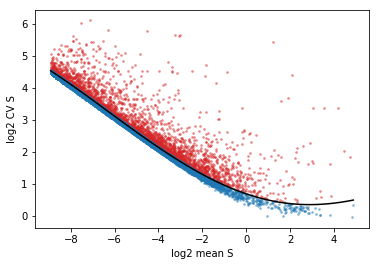

In [103]:

vlm.normalize("S", size=True, log=True)


vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.5))

vlm.score_detection_levels(min_expr_counts=30, min_cells_express=20)
vlm.filter_genes(by_detection_levels=True)
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)

vlm.filter_genes(by_cv_vs_mean=True)

vlm._normalize_S(relative_size=vlm.S.sum(0),
             target_size=vlm.S.sum(0).mean())
vlm._normalize_U(relative_size=vlm.U.sum(0),
             target_size=vlm.U.sum(0).mean())
vlm.perform_PCA()
vlm.knn_imputation(n_pca_dims=20,
                   k = int(len(vlm.ca["CellID"]) * 0.075),
                   balanced=True,
                   b_sight=3000, b_maxl=1500, n_jobs=6)
vlm.fit_gammas()
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)



{'CellID': array(['1_control:AAAGTGAGTCTGTGGCx', '1_control:AAAGGGCTCATCCTGCx',
        '1_control:AAAGGATTCAGTGGGAx', ..., '2_mutant:TTTGGTTTCTTCGGTCx',
        '2_mutant:TTTGATCAGGCTAAATx', '2_mutant:TTTGACTGTATGCGTTx'],
       dtype=object),
 'Clusters': array([11,  8, 13, ...,  5,  6, 13]),
 '_X': array([-12.668505 ,  37.716885 , -18.861511 , ..., -29.480976 ,
          1.3637298,  35.521515 ], dtype=float32),
 '_Y': array([-47.72548 ,  13.760324,  27.186083, ..., -31.729492,  25.10111 ,
         14.095046], dtype=float32),
 'UMAP1': array([  7.44356251,   4.03804016,   5.70883942, ..., -12.06051445,
        -12.02686024, -12.00004864]),
 'UMAP2': array([-3.84471154, -4.85181475, -5.50793314, ...,  3.91271114,
         3.69958544,  3.58973169])}

In [104]:

vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt",
                             psc=1, n_neighbors= int(vlm.S.shape[1] / 5),
                             knn_random=True, sampled_fraction=0.5)
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)
vlm.calculate_grid_arrows(smooth = 0.5,
                          steps=(30, 30),
                          n_neighbors=int(vlm.S.shape[1] * 0.10))



2019-11-12 12:59:21,932 - DEBUG - Calculate KNN in the embedding space


/miniconda3/lib/python3.6/site-packages/velocyto/analysis.py:1564: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  p=p) for i in range(neigh_ixs.shape[0])), 0)


2019-11-12 12:59:35,417 - DEBUG - Correlation Calculation 'knn_random'
2019-11-12 13:06:37,340 - DEBUG - Correlation Calculation for negative control
2019-11-12 13:13:30,309 - DEBUG - Done Correlation Calculation
2019-11-12 13:13:30,475 - DEBUG - Calculate transition probability
2019-11-12 13:13:37,434 - DEBUG - Calculate transition probability for negative control


In [109]:
vlm.to_hdf5("eickelberg_velo_analysis.h5")

TypeError: No conversion path for dtype: dtype('<U47')

2019-11-12 13:16:55,457 - DEBUG - update_title_pos
2019-11-12 13:16:59,265 - DEBUG - update_title_pos
2019-11-12 13:16:59,692 - DEBUG - update_title_pos
2019-11-12 13:17:01,706 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2019-11-12 13:17:01,709 - DEBUG - Assigning font /b'F1' = '/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2019-11-12 13:17:01,754 - DEBUG - update_title_pos
2019-11-12 13:17:03,599 - DEBUG - Embedding font /miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2019-11-12 13:17:03,600 - DEBUG - Writing TrueType font.
2019-11-12 13:17:03,641 - DEBUG - update_title_pos
2019-11-12 13:17:03,734 - DEBUG - update_title_pos
2019-11-12 13:17:03,904 - DEBUG - update_title_pos
2019-11-12 13:17:05,814 - DEBUG - updat

2019-11-12 13:17:06,092 - DEBUG - update_title_pos
2019-11-12 13:17:06,162 - DEBUG - update_title_pos
2019-11-12 13:17:07,251 - DEBUG - update_title_pos
2019-11-12 13:17:07,402 - DEBUG - update_title_pos
2019-11-12 13:17:07,507 - DEBUG - update_title_pos


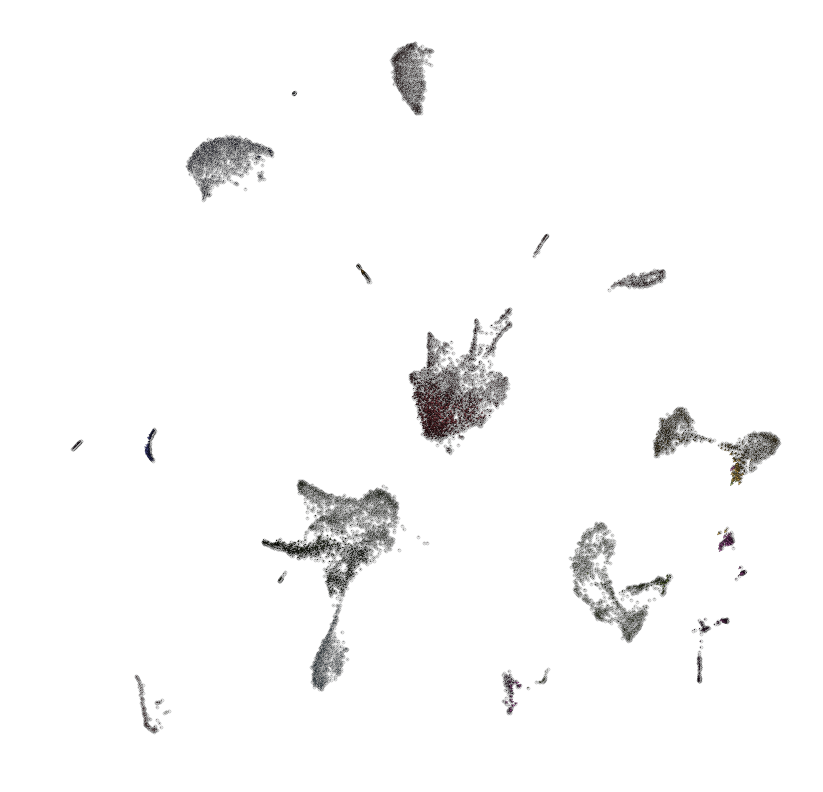

2019-11-12 13:17:07,893 - DEBUG - update_title_pos
2019-11-12 13:17:08,040 - DEBUG - update_title_pos
2019-11-12 13:17:08,261 - DEBUG - update_title_pos
2019-11-12 13:17:08,346 - DEBUG - update_title_pos
2019-11-12 13:17:08,485 - DEBUG - update_title_pos
2019-11-12 13:17:08,548 - DEBUG - update_title_pos
2019-11-12 13:17:08,607 - DEBUG - update_title_pos
2019-11-12 13:17:08,694 - DEBUG - update_title_pos


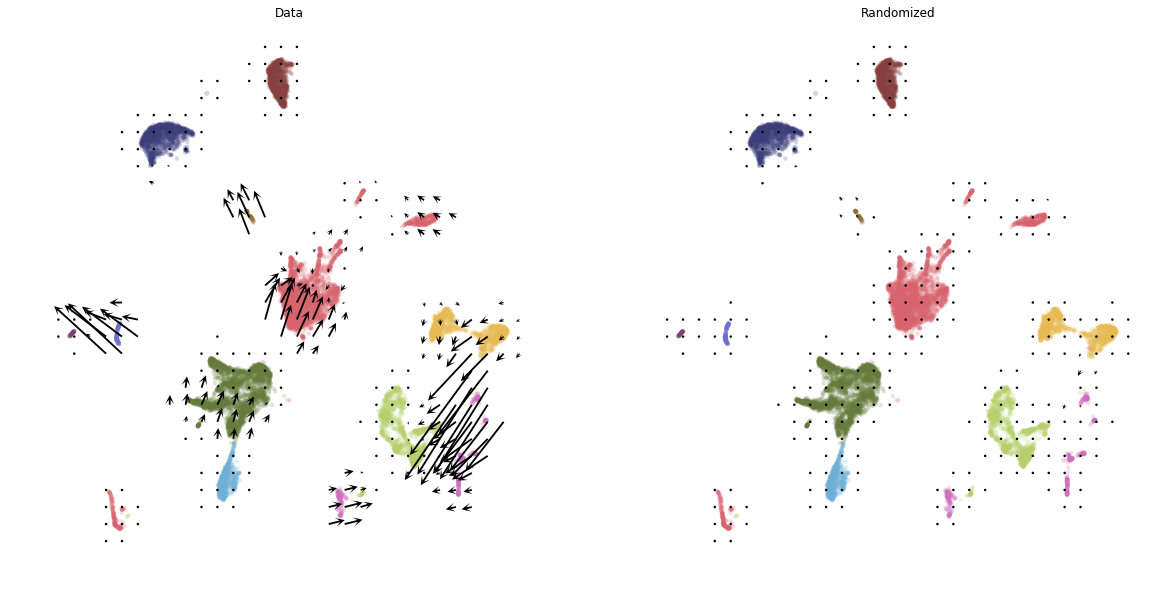

2019-11-12 13:17:08,913 - DEBUG - update_title_pos
2019-11-12 13:17:09,129 - DEBUG - update_title_pos
2019-11-12 13:17:09,211 - DEBUG - update_title_pos
2019-11-12 13:17:09,252 - DEBUG - update_title_pos


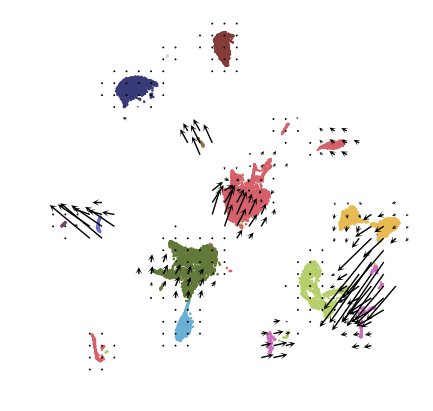

2019-11-12 13:17:09,458 - DEBUG - update_title_pos
2019-11-12 13:17:09,532 - DEBUG - update_title_pos
2019-11-12 13:17:09,572 - DEBUG - update_title_pos
2019-11-12 13:17:09,595 - DEBUG - update_title_pos


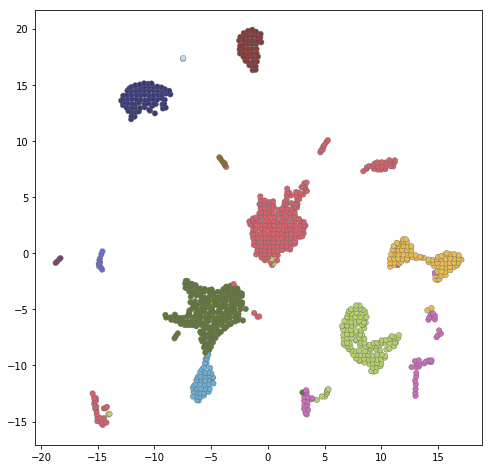

In [105]:
out_dir = "."
sample_id = "bg_corrected"

plt.figure(None,(14,14))
quiver_scale = 60
plt.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors="k", color=vlm.colorandum[ix_choice], alpha=1)
plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
           vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")

plt.savefig(os.path.join(out_dir, sample_id + "_full_arrows.pdf"))



plt.figure(None,(20,10))
vlm.plot_grid_arrows(quiver_scale="auto",
                     headaxislength=2.75,
                     headlength=5,
                     headwidth=4.8,
                     minlength=1.5,
                     plot_random=True,
                     scale_type="relative")
              #       scatter_kwargs_dict = {'alpha' : 1})

plt.savefig(os.path.join(out_dir, sample_id + "_vectorfield.pdf"))

plt.figure(None,(7,7))
vlm.plot_grid_arrows(quiver_scale="auto",
                     headaxislength=2.75,
                     headlength=5,
                     headwidth=4.8,
                     minlength=1.5,
                     plot_random=False,
                     scale_type="relative",
                     scatter_kwargs_dict = {'alpha' : 1,
                                            's' : 2.5,
                                            'lw' : 1})
plt.savefig(os.path.join(out_dir, sample_id + "_vectorfield_pub.pdf"), transparent = True)


## Markov Chain analysis

# Sample uniformly the points to avoid density driven effects - Should reimplement as a method
steps = 100, 100
grs = []
for dim_i in range(vlm.embedding.shape[1]):
    m, M = np.min(vlm.embedding[:, dim_i]), np.max(vlm.embedding[:, dim_i])
    m = m - 0.025 * np.abs(M - m)
    M = M + 0.025 * np.abs(M - m)
    gr = np.linspace(m, M, steps[dim_i])
    grs.append(gr)

meshes_tuple = np.meshgrid(*grs)
gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T

from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors()
nn.fit(vlm.embedding)
dist, ixs = nn.kneighbors(gridpoints_coordinates, 1)

diag_step_dist = np.sqrt((meshes_tuple[0][0,0] - meshes_tuple[0][0,1])**2 + (meshes_tuple[1][0,0] - meshes_tuple[1][1,0])**2)
min_dist = diag_step_dist / 2
ixs = ixs[dist < min_dist]
gridpoints_coordinates = gridpoints_coordinates[dist.flat[:]<min_dist,:]
dist = dist[dist < min_dist]

ixs = np.unique(ixs)

plt.figure(None,(8,8))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=vlm.colorandum[ixs], alpha=1, s=30, lw=0.4,
                edgecolor="0.4")



Normalized count data: X, spliced, unspliced.
Logarithmized X.


2019-11-12 13:20:16,297 - DEBUG - update_title_pos
2019-11-12 13:20:16,403 - DEBUG - update_title_pos
2019-11-12 13:20:16,433 - DEBUG - update_title_pos
2019-11-12 13:20:16,543 - DEBUG - update_title_pos
2019-11-12 13:20:17,246 - DEBUG - update_title_pos
2019-11-12 13:20:17,353 - DEBUG - update_title_pos
2019-11-12 13:20:17,388 - DEBUG - update_title_pos
2019-11-12 13:20:17,507 - DEBUG - update_title_pos
2019-11-12 13:20:17,551 - DEBUG - update_title_pos
2019-11-12 13:20:17,592 - DEBUG - update_title_pos
2019-11-12 13:20:17,624 - DEBUG - update_title_pos
2019-11-12 13:20:17,640 - DEBUG - update_title_pos


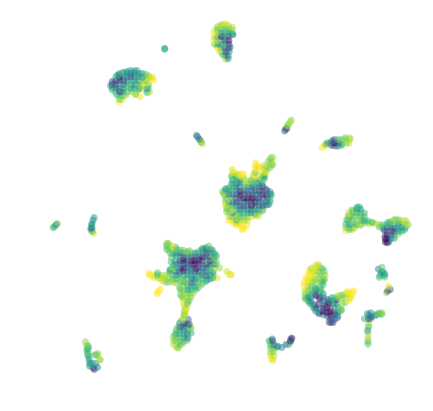

2019-11-12 13:20:17,695 - DEBUG - update_title_pos
2019-11-12 13:20:17,739 - DEBUG - update_title_pos
2019-11-12 13:20:17,762 - DEBUG - update_title_pos
2019-11-12 13:20:17,782 - DEBUG - update_title_pos


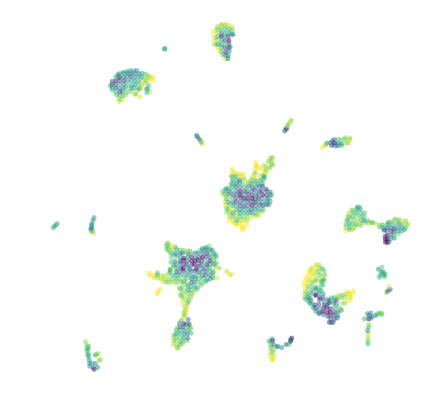

2019-11-12 13:20:17,845 - DEBUG - update_title_pos
2019-11-12 13:20:17,897 - DEBUG - update_title_pos
2019-11-12 13:20:17,925 - DEBUG - update_title_pos
2019-11-12 13:20:17,943 - DEBUG - update_title_pos


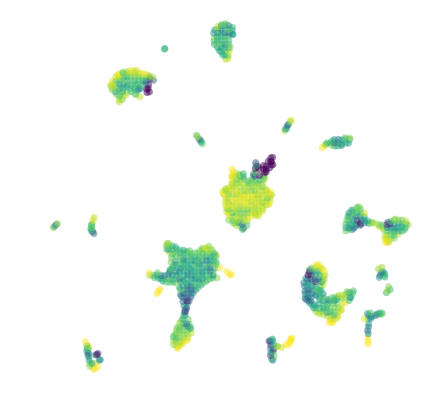

2019-11-12 13:20:17,999 - DEBUG - update_title_pos
2019-11-12 13:20:18,037 - DEBUG - update_title_pos
2019-11-12 13:20:18,067 - DEBUG - update_title_pos
2019-11-12 13:20:18,084 - DEBUG - update_title_pos


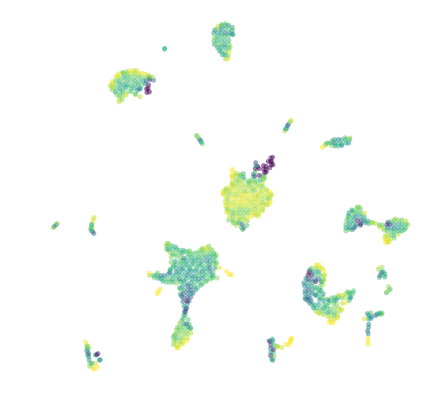

In [106]:
nsteps = 500
sample_id = "short_diffusion_0.5k"
vlm.prepare_markov(sigma_D=diag_step_dist,
                   sigma_W=diag_step_dist/2.,
                   direction='forward', cells_ixs=ixs)

vlm.run_markov(starting_p=np.ones(len(ixs)), n_steps= nsteps)


diffused_n = vlm.diffused - np.percentile(vlm.diffused, 3)
diffused_n /= np.percentile(diffused_n, 97)
diffused_n = np.clip(diffused_n, 0, 1)

plt.figure(None,(7,7))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_n, alpha=0.5, s=50, lw=0.,
                edgecolor="", cmap="viridis_r", rasterized=False)
plt.axis("off")
plt.savefig(os.path.join(out_dir, sample_id + "_endpoint_distr.pdf"))


plt.figure(None,(7,7))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_n, alpha=0.5, s=25, lw=0.,
                edgecolor="", cmap="viridis_r", rasterized=False)
plt.axis("off")
plt.savefig(os.path.join(out_dir, sample_id + "_endpoint_distr_pub.pdf"), transparent = True)

out_df = pd.DataFrame({"CellID" : vlm.ca["CellID"][ixs],
                       "endpoints" : diffused_n})


vlm.prepare_markov(sigma_D=diag_step_dist,
                   sigma_W=diag_step_dist/2.,
                   direction='backwards', cells_ixs=ixs)
vlm.run_markov(starting_p=np.ones(len(ixs)), n_steps= nsteps)

diffused_n = vlm.diffused - np.percentile(vlm.diffused, 3)
diffused_n /= np.percentile(diffused_n, 97)
diffused_n = np.clip(diffused_n, 0, 1)

plt.figure(None,(7,7))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_n, alpha=0.5, s=50, lw=0.,
                edgecolor="", cmap="viridis_r", rasterized=False)
plt.axis("off")
plt.savefig(os.path.join(out_dir, sample_id + "_startpoint_distr.pdf"))

plt.figure(None,(7,7))
vcy.scatter_viz(vlm.embedding[ixs, 0], vlm.embedding[ixs, 1],
                c=diffused_n, alpha=0.5, s=25, lw=0.,
                edgecolor="", cmap="viridis_r", rasterized=False)
plt.axis("off")
plt.savefig(os.path.join(out_dir, sample_id + "_startpoint_distr_pub.pdf"), transparent = True)


out_df["startpoints"] = diffused_n

out_df.to_csv(os.path.join(out_dir, sample_id + "_markov_points.tsv"),  sep = "\t", index = False)

 

TypeError: No conversion path for dtype: dtype('<U3')

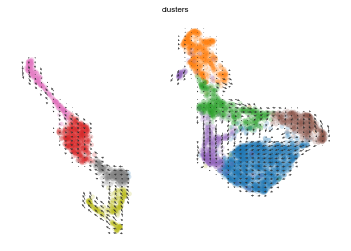

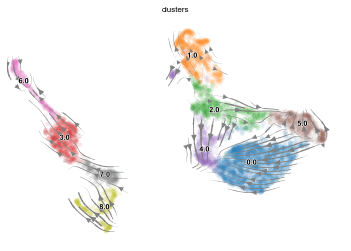

'0.1.23'